# Outlier detection methods

# Introduction

Inclure les valeurs aberrantes dans les modèles basés sur les données pourrait être risqué. L'existence d'une valeur extrême unique et trompeuse a le potentiel de changer la conclusion impliquée par le modèle. Il est donc important de gérer ce type de risque.

Cette étude **explique** six des méthodes de détection des valeurs aberrantes les plus populaires :
* La méthode de l'étendue interquartile de Tukey
* La méthode de l'écart-type 
* La méthode du z-score
* Le z-score modifié
* La Forêt d'Isolation
* DBSCAN - Clustering Spatial Basé sur la Densité des Applications avec Bruit

L'objectif de cette étude est de présenter des méthodes utiles pour détecter et supprimer les valeurs aberrantes dans un jeu de données. Certaines d'entre elles sont sensibles aux valeurs extrêmes comme la méthode de l'écart-type, et d'autres sont résistantes aux valeurs extrêmes, comme la méthode de Tukey.

# 1. Set-up

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from collections import Counter


In [9]:
df_raw = pd.read_csv('creditcard.csv')
df=df_raw.drop(['Time'], axis=1)


In [10]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [11]:
feature_list = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

### Visualisations de certains feactures

In [21]:
"""fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(11,17))
fig.suptitle('Features vs Class\n', size = 18)

sns.boxplot(ax=axes[0, 0], data=df, x='Class', y='V17', palette='Spectral')
axes[0,0].set_title("V17 distribution");

sns.boxplot(ax=axes[0, 1], data=df, x='Class', y='V10', palette='Spectral')
axes[0,1].set_title("V10 distribution");

sns.boxplot(ax=axes[0, 2], data=df, x='Class', y='V12', palette='Spectral')
axes[0,2].set_title("V12 distribution");

sns.boxplot(ax=axes[1, 0], data=df, x='Class', y='V16', palette='Spectral')
axes[1,0].set_title("V16 distribution");

sns.boxplot(ax=axes[1, 1], data=df, x='Class', y='V14', palette='Spectral')
axes[1,1].set_title("V14 distribution");

sns.boxplot(ax=axes[1, 2], data=df, x='Class', y='V3', palette='Spectral')
axes[1,2].set_title("V3 distribution");

sns.boxplot(ax=axes[2, 0], data=df, x='Class', y='V7', palette='Spectral')
axes[2,0].set_title("V7 distribution");

sns.boxplot(ax=axes[2, 1], data=df, x='Class', y='V11', palette='Spectral')
axes[2,1].set_title("V11 distribution");

sns.boxplot(ax=axes[2, 2], data=df, x='Class', y='V4', palette='Spectral')
axes[2,2].set_title("V4 distribution");

plt.tight_layout()"""

'fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(11,17))\nfig.suptitle(\'Features vs Class\n\', size = 18)\n\nsns.boxplot(ax=axes[0, 0], data=df, x=\'Class\', y=\'V17\', palette=\'Spectral\')\naxes[0,0].set_title("V17 distribution");\n\nsns.boxplot(ax=axes[0, 1], data=df, x=\'Class\', y=\'V10\', palette=\'Spectral\')\naxes[0,1].set_title("V10 distribution");\n\nsns.boxplot(ax=axes[0, 2], data=df, x=\'Class\', y=\'V12\', palette=\'Spectral\')\naxes[0,2].set_title("V12 distribution");\n\nsns.boxplot(ax=axes[1, 0], data=df, x=\'Class\', y=\'V16\', palette=\'Spectral\')\naxes[1,0].set_title("V16 distribution");\n\nsns.boxplot(ax=axes[1, 1], data=df, x=\'Class\', y=\'V14\', palette=\'Spectral\')\naxes[1,1].set_title("V14 distribution");\n\nsns.boxplot(ax=axes[1, 2], data=df, x=\'Class\', y=\'V3\', palette=\'Spectral\')\naxes[1,2].set_title("V3 distribution");\n\nsns.boxplot(ax=axes[2, 0], data=df, x=\'Class\', y=\'V7\', palette=\'Spectral\')\naxes[2,0].set_title("V7 distribution");\n\nsn

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_features_by_class_boxplot(data, columns):
    """
    Plot box plots of features by class.
    
    Args:
        data (pandas.DataFrame): The input DataFrame.
        columns (list): List of column names to plot.
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 17))
    fig.suptitle('Features vs Class\n', size=18)
    
    for i, col in enumerate(columns):
        row = i // 3
        col_idx = i % 3
        sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
        axes[row, col_idx].set_title(f"{col} distribution")
    
    plt.tight_layout()
    return fig, axes



/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` wi

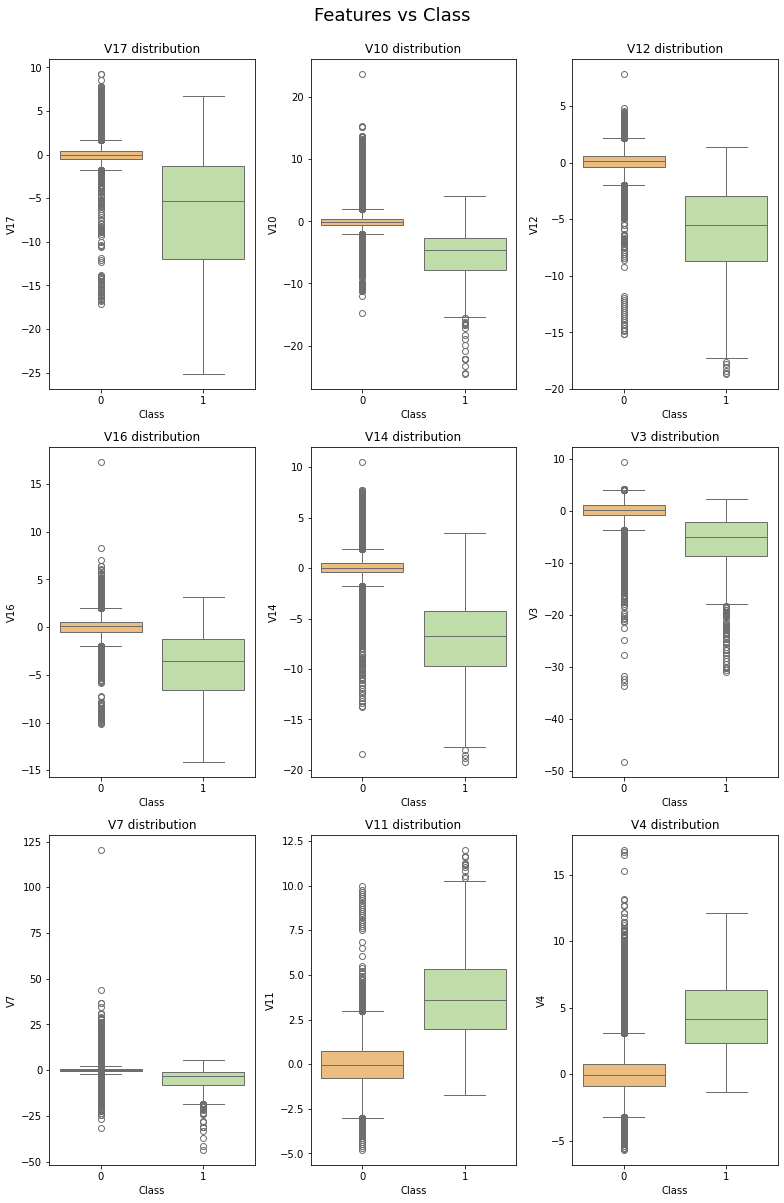

In [25]:
# Utilisation de la fonction
fig, axes = plot_features_by_class_boxplot(df, ['V17', 'V10', 'V12', 'V16', 'V14', 'V3', 'V7', 'V11', 'V4'])

In [20]:
"""fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Features vs Class\n', size = 18)

axes[0,0].hist(df['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()"""

'fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))\nfig.suptitle(\'Features vs Class\n\', size = 18)\n\naxes[0,0].hist(df[\'V17\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[0,0].set_title("V17 distribution");\n\naxes[0,1].hist(df[\'V10\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[0,1].set_title("V10 distribution");\n\naxes[0,2].hist(df[\'V12\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[0,2].set_title("V12 distribution");\n\naxes[1,0].hist(df[\'V16\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[1,0].set_title("V16 distribution");\n\naxes[1,1].hist(df[\'V14\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[1,1].set_title("V14 distribution");\n\naxes[1,2].hist(df[\'V3\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[1,2].set_title("V3 distribution");\n\naxes[2,0].hist(df[\'V7\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[2,0].set_title("V7 distribution");\n\naxes[2,1].hist(df[\'V11\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[2,1

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_histograms(data, columns):
    """
    Plot histograms of features.
    
    Args:
        data (pandas.DataFrame): The input DataFrame.
        columns (list): List of column names to plot.
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 8))
    fig.suptitle('Distributions of features \n', size=18)
    
    for i, col in enumerate(columns):
        row = i // 3
        col_idx = i % 3
        axes[row, col_idx].hist(data[col], bins=60, linewidth=0.5, edgecolor="white")
        axes[row, col_idx].set_title(f"{col} distribution")
    
    plt.tight_layout()
    return fig, axes



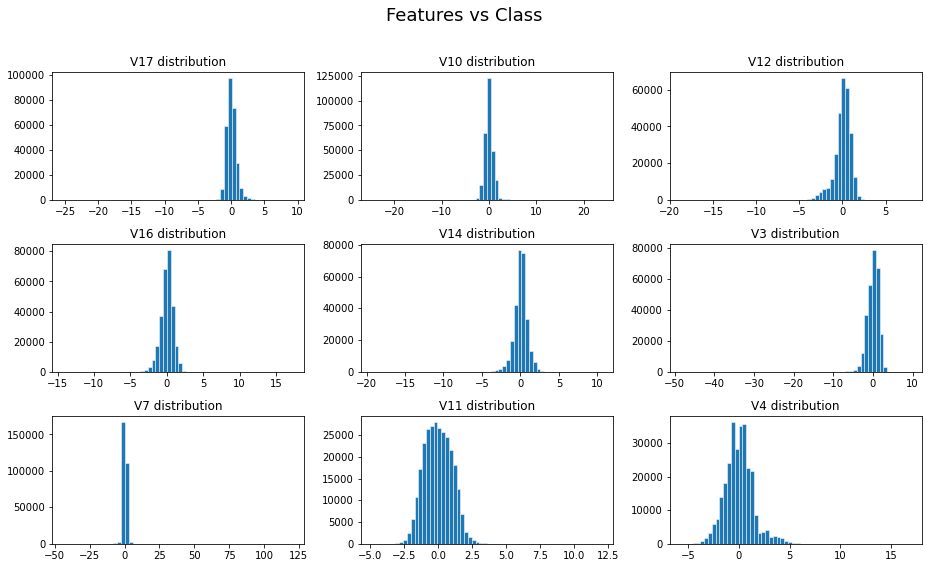

In [23]:
# Utilisation de la fonction
fig, axes = plot_feature_histograms(df, ['V17', 'V10', 'V12', 'V16', 'V14', 'V3', 'V7', 'V11', 'V4'])

# 2. Tukey's IQR method

La méthode de Tukey  est une technique très répandue pour détecter les valeurs aberrantes, car elle ne nécessite aucune hypothèse sur la forme de la distribution des données. Cette approche est particulièrement utile lorsque les données présentent une asymétrie ou s'écartent d'une distribution normale (en cloche).

L'avantage de la méthode de Tukey est qu'elle est robuste aux distributions non gaussiennes, ce qui la rend plus appropriée que d'autres méthodes basées sur des hypothèses de normalité, surtout lorsqu'on travaille sur des jeux de données de petite taille. En effet, les tests paramétriques classiques peuvent manquer de puissance avec de petits échantillons.

La procédure consiste à :
1. Calculer le premier quartile (Q1) et le troisième quartile (Q3) de la distribution.
2. En déduire l'écart interquartile (IQR = Q3 - Q1), qui est une mesure de dispersion robuste aux valeurs aberrantes.
3. Définir les limites de la plage de normalité comme Q1 - 1,5 × IQR pour la borne inférieure, et Q3 + 1,5 × IQR pour la borne supérieure.
4. Tout point de données en dehors de cette plage est alors considéré comme une valeur aberrante et peut être supprimé pour la suite de l'analyse.

Cette méthode présente l'avantage d'être simple à mettre en œuvre et de fournir des résultats interprétables. Elle est donc largement utilisée en pratique, notamment lorsque les hypothèses de normalité ne sont pas vérifiées.

In [27]:
from IPython.display import Image
img = 'IQR.png'
Image(url=img, width=800)

In [158]:
import numpy as np
from collections import Counter

def detect_outliers_IQR(df, n, features):
    """
    Prend un dataframe et renvoie une liste d'indices correspondant aux observations
    contenant plus de n outliers selon la méthode IQR (Écart InterQuartile) de Tukey.
    
    Args:
    df (pandas.DataFrame): le dataframe à analyser
    n (int): le nombre d'outliers maximum toléré par observation
    features (list): la liste des caractéristiques à analyser
    
    Returns:
    list: la liste des indices des observations contenant plus de n outliers
    """
    outlier_indices = []
    
    for feature in features:
        # Calcul du 1er quartile (25%), 3ème quartile (75%) et de l'écart interquartile (EIQ)
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calcul du seuil d'outlier
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Détermination des indices des outliers pour cette caractéristique
        outlier_indices_feature = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
        outlier_indices.extend(outlier_indices_feature)
    
    # Suppression des doublons dans la liste des indices d'outliers
    #outlier_indices = list(set(outlier_indices))
    
    # Sélection des observations contenant plus de n outliers
    multi_outlier_observations = [k for k, v in Counter(outlier_indices).items() if v >= n]
    
    return multi_outlier_observations

Le but de ce code est de détecter les observations (lignes) dans un dataframe qui sont considérées comme des outliers (valeurs aberrantes) selon la méthode de l'écart interquartile (IQR) de Tukey.

Cela permet d'identifier les observations les plus aberrantes dans le dataframe, en se basant sur la méthode IQR qui est une méthode statistique robuste pour détecter les outliers.

In [169]:
# detecting outliers
Outliers_IQR = detect_outliers_IQR(df,1,feature_list)
Outliers_IQR


[18,
 85,
 140,
 146,
 164,
 174,
 210,
 290,
 401,
 811,
 827,
 1158,
 1608,
 1632,
 1753,
 1813,
 1911,
 1922,
 2059,
 2178,
 2186,
 2234,
 2278,
 2301,
 2386,
 2464,
 2475,
 2589,
 2611,
 2682,
 2791,
 2792,
 2897,
 2951,
 2954,
 2957,
 2963,
 3278,
 3282,
 3443,
 3505,
 3509,
 3547,
 3554,
 3555,
 3602,
 4235,
 4415,
 4608,
 4675,
 4740,
 4776,
 4810,
 4895,
 4926,
 4950,
 5139,
 5257,
 5296,
 5306,
 5371,
 5392,
 5401,
 5425,
 5504,
 5512,
 5526,
 5534,
 5535,
 5615,
 5652,
 5676,
 5715,
 5733,
 5797,
 5827,
 5888,
 6108,
 6223,
 6286,
 6300,
 6305,
 6306,
 6330,
 6341,
 6410,
 6411,
 6412,
 6413,
 6467,
 6501,
 6547,
 6590,
 6624,
 6692,
 6727,
 6783,
 6788,
 6812,
 6882,
 6905,
 6908,
 6934,
 6940,
 6947,
 6958,
 6969,
 7057,
 7074,
 7075,
 7080,
 7081,
 7090,
 7098,
 7104,
 7108,
 7127,
 7144,
 7163,
 7164,
 7178,
 7246,
 7255,
 7261,
 7277,
 7304,
 7348,
 7415,
 7420,
 7455,
 7485,
 7513,
 7522,
 7523,
 7539,
 7560,
 7574,
 7578,
 7580,
 7596,
 7616,
 7617,
 7675,
 7697,
 7743

In [235]:
len(Outliers_IQR)

138473

In [170]:

# dropping outliers
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)


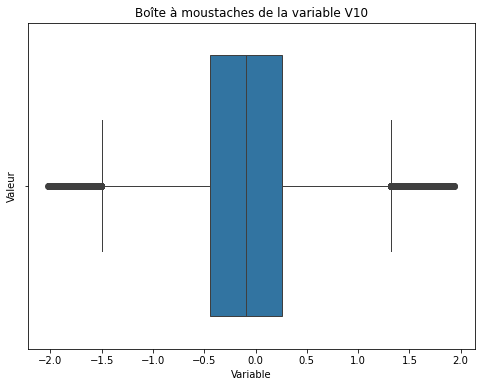

In [171]:

# Créer la boîte à moustaches avec Seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='V10', data=df_out, ax=ax)

# Ajouter des étiquettes et un titre
ax.set_xlabel('Variable')
ax.set_ylabel('Valeur')
ax.set_title('Boîte à moustaches de la variable V10')

# Afficher le graphique
plt.show()

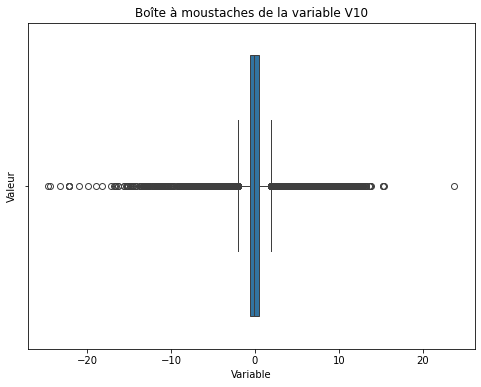

In [172]:
# Créer la boîte à moustaches avec Seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='V10', data=df, ax=ax)

# Ajouter des étiquettes et un titre
ax.set_xlabel('Variable')
ax.set_ylabel('Valeur')
ax.set_title('Boîte à moustaches de la variable V10')

# Afficher le graphique
plt.show()

/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` wi

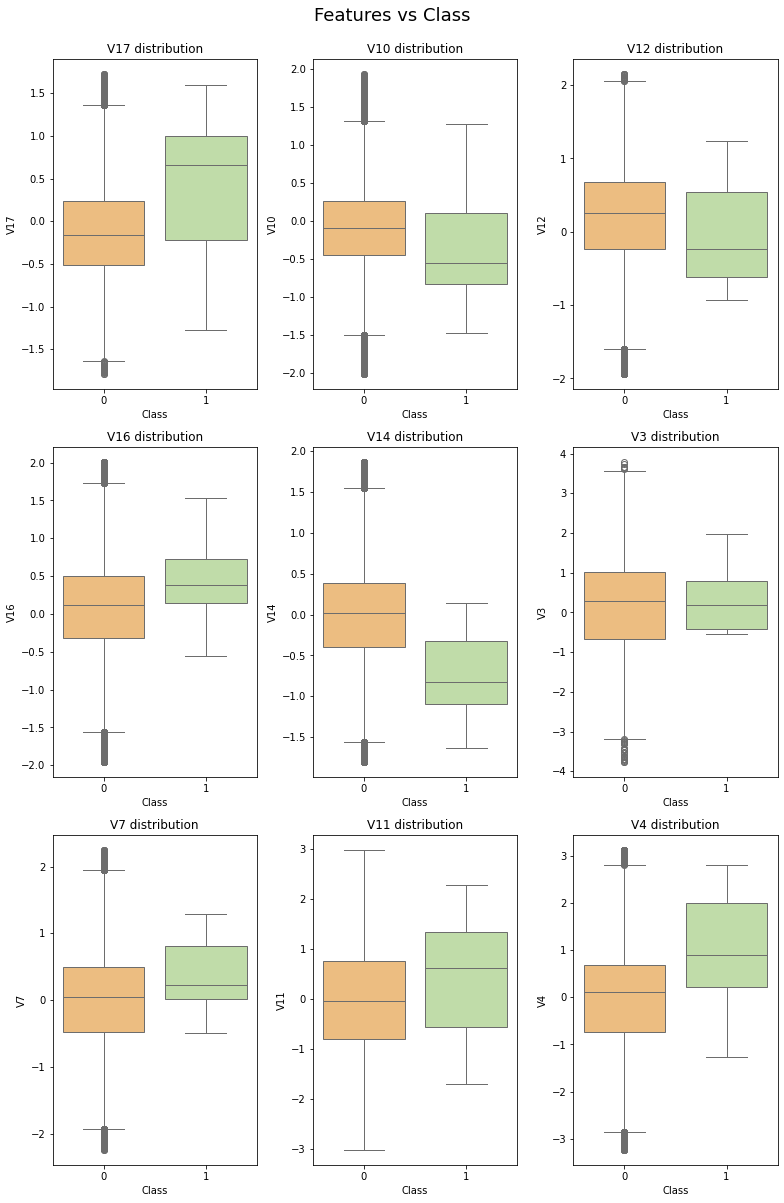

In [173]:

# Utilisation de la fonction
fig, axes = plot_features_by_class_boxplot(df_out, ['V17', 'V10', 'V12', 'V16', 'V14', 'V3', 'V7', 'V11', 'V4'])

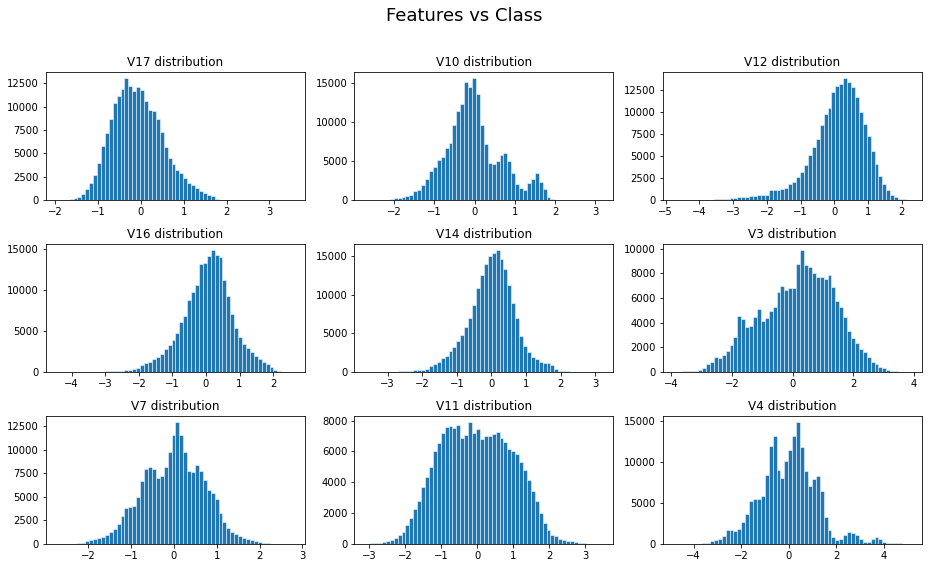

In [32]:
# Utilisation de la fonction
fig, axes = plot_feature_histograms(df_out, ['V17', 'V10', 'V12', 'V16', 'V14', 'V3', 'V7', 'V11', 'V4'])

In [33]:
"""# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using IQR Method\n', size = 18)

axes[0,0].hist(df_out['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()"""

'# Checking distributions of most important features after dropping outliers\n\nfig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))\nfig.suptitle(\'Distributions of most important features after dropping outliers using IQR Method\n\', size = 18)\n\naxes[0,0].hist(df_out[\'V17\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[0,0].set_title("V17 distribution");\n\naxes[0,1].hist(df_out[\'V10\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[0,1].set_title("V10 distribution");\n\naxes[0,2].hist(df_out[\'V12\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[0,2].set_title("V12 distribution");\n\naxes[1,0].hist(df_out[\'V16\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[1,0].set_title("V16 distribution");\n\naxes[1,1].hist(df_out[\'V14\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[1,1].set_title("V14 distribution");\n\naxes[1,2].hist(df_out[\'V3\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[1,2].set_title("V3 distribution");\n\naxes[2,0].hist(df_out[\'V7\

# 3. Standard deviation method

Si nous savons que **la distribution des valeurs dans l'échantillon est gaussienne ou proche d'une gaussienne**, nous pouvons utiliser l'écart-type de l'échantillon comme seuil pour identifier les valeurs aberrantes.

L'écart-type indique à quel point les données individuelles sont dispersées autour de la moyenne. Si la distribution des données suit une loi normale, alors :
* 68% des valeurs se trouvent dans un intervalle d'un écart-type autour de la moyenne
* 95% se trouvent dans un intervalle de deux écarts-types
* 99,7% se trouvent dans un intervalle de trois écarts-types

Selon les spécifications du jeu de données, on peut détecter et supprimer les valeurs aberrantes en utilisant un seuil à 2 ou 3 fois l'écart-type.

Cependant, cette méthode peut échouer à détecter les valeurs aberrantes car celles-ci augmentent l'écart-type. Plus l'outlier est extrême, plus l'écart-type est affecté.

In [37]:
liste_caracteristiques=['V17', 'V10', 'V12', 'V16', 'V14', 'V3', 'V7', 'V11', 'V4']

In [190]:
import scipy.stats as stats
import matplotlib.pyplot as plt

def check_normality_multiple(df, features):
    """
    Vérifie si les variables dans la liste 'features' du dataframe 'df' ont une distribution normale en utilisant plusieurs tests.
    
    Paramètres:
    df (pandas.DataFrame) : le dataframe contenant les variables à tester
    features (list) : la liste des noms de variables à tester
    
    Renvoie:
    dict : un dictionnaire indiquant pour chaque variable le résultat des différents tests de normalité
    """
    normality_results = {}
    
    for feature in features:
        # Test de Shapiro-Wilk
        _, p_value_shapiro = stats.shapiro(df[feature])
        
        # Test de Kolmogorov-Smirnov
        #_, p_value_ks, _ = stats.kstest(df[feature], 'norm')
        
        # Coefficient d'asymétrie et d'aplatissement
        skewness = stats.skew(df[feature])
        kurtosis = stats.kurtosis(df[feature])
        
        # Vérifier visuellement
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        df[feature].hist(bins=30)
        plt.subplot(1, 2, 2)
        stats.probplot(df[feature], plot=plt)
        plt.suptitle(f"Normalité de la variable '{feature}'")
        plt.show()
        
        # Rassembler les résultats
        normality_results[feature] = {
            'Shapiro-Wilk': p_value_shapiro > 0.05,
            #'Kolmogorov-Smirnov': p_value_ks > 0.05,
            'Skewness': abs(skewness) < 0.5,
            'Kurtosis': abs(kurtosis - 3) < 1
        }
    
    return normality_results

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 284807.
  res = hypotest_fun_out(*samples, **kwds)


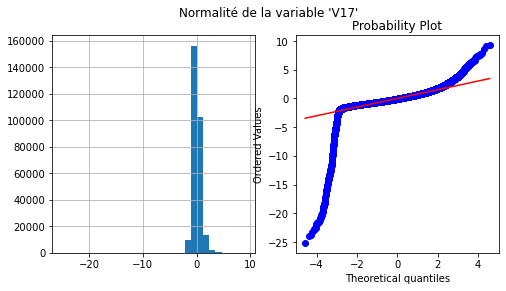

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 284807.
  res = hypotest_fun_out(*samples, **kwds)


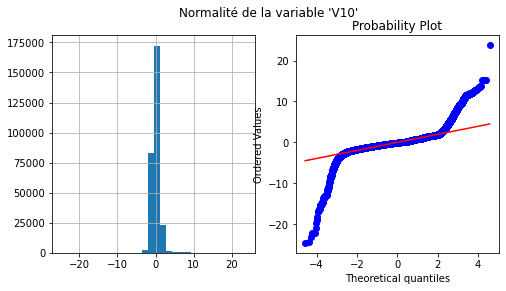

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 284807.
  res = hypotest_fun_out(*samples, **kwds)


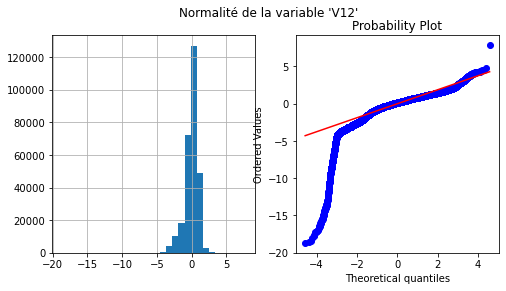

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 284807.
  res = hypotest_fun_out(*samples, **kwds)


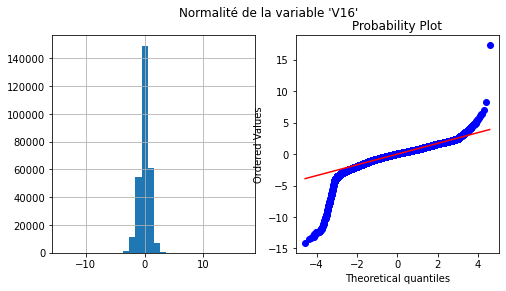

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 284807.
  res = hypotest_fun_out(*samples, **kwds)


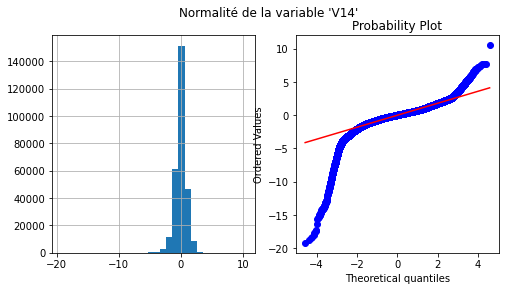

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 284807.
  res = hypotest_fun_out(*samples, **kwds)


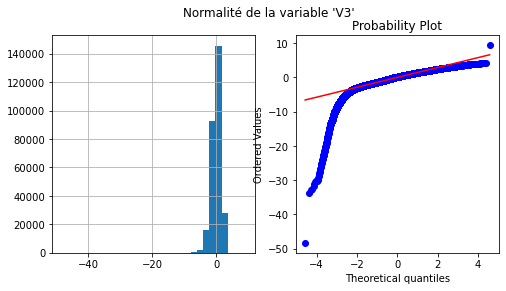

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 284807.
  res = hypotest_fun_out(*samples, **kwds)


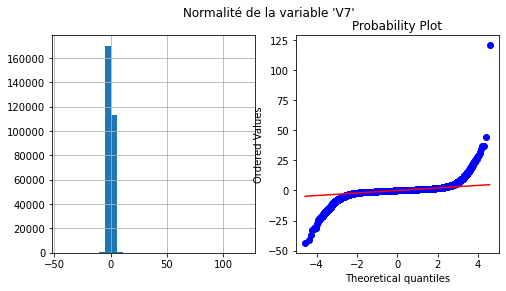

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 284807.
  res = hypotest_fun_out(*samples, **kwds)


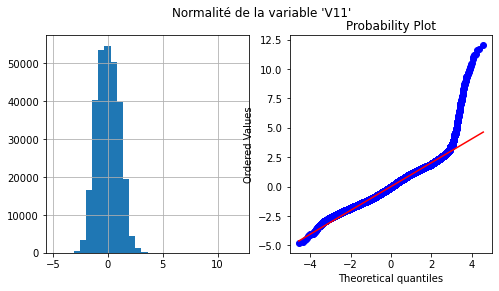

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 284807.
  res = hypotest_fun_out(*samples, **kwds)


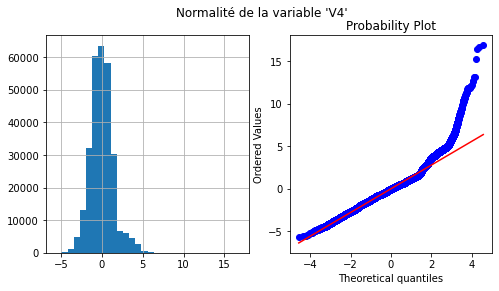

{'V17': {'Shapiro-Wilk': False, 'Skewness': False, 'Kurtosis': False},
 'V10': {'Shapiro-Wilk': False, 'Skewness': False, 'Kurtosis': False},
 'V12': {'Shapiro-Wilk': False, 'Skewness': False, 'Kurtosis': False},
 'V16': {'Shapiro-Wilk': False, 'Skewness': False, 'Kurtosis': False},
 'V14': {'Shapiro-Wilk': False, 'Skewness': False, 'Kurtosis': False},
 'V3': {'Shapiro-Wilk': False, 'Skewness': False, 'Kurtosis': False},
 'V7': {'Shapiro-Wilk': False, 'Skewness': False, 'Kurtosis': False},
 'V11': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False},
 'V4': {'Shapiro-Wilk': False, 'Skewness': False, 'Kurtosis': True}}

In [191]:
vars_dist_nor = check_normality_multiple(df, liste_caracteristiques)
vars_dist_nor 

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 146334.
  res = hypotest_fun_out(*samples, **kwds)


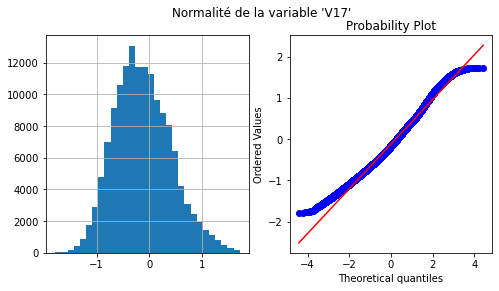

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 146334.
  res = hypotest_fun_out(*samples, **kwds)


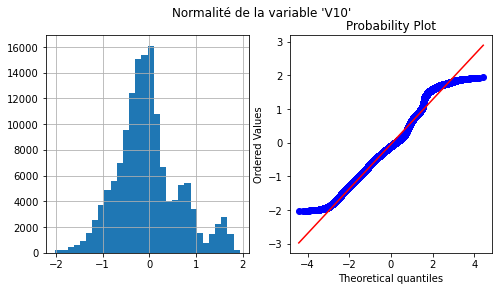

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 146334.
  res = hypotest_fun_out(*samples, **kwds)


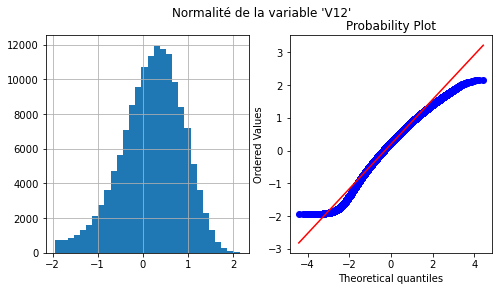

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 146334.
  res = hypotest_fun_out(*samples, **kwds)


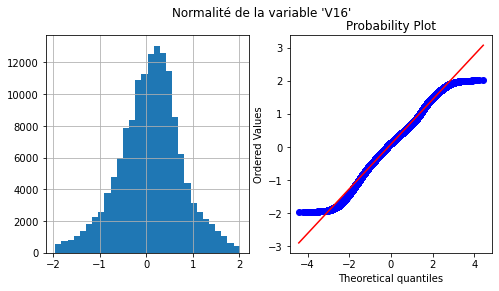

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 146334.
  res = hypotest_fun_out(*samples, **kwds)


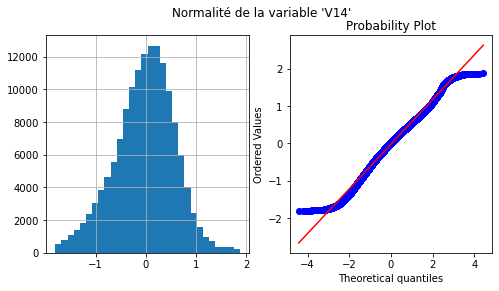

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 146334.
  res = hypotest_fun_out(*samples, **kwds)


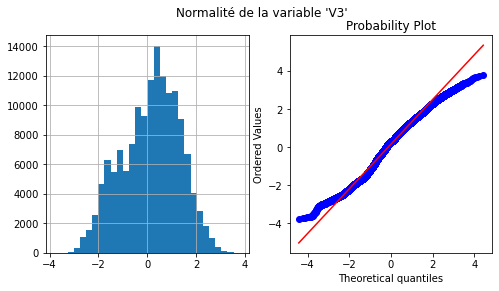

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 146334.
  res = hypotest_fun_out(*samples, **kwds)


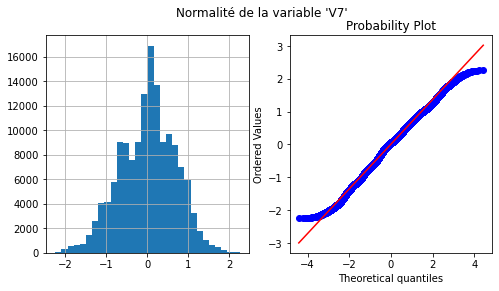

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 146334.
  res = hypotest_fun_out(*samples, **kwds)


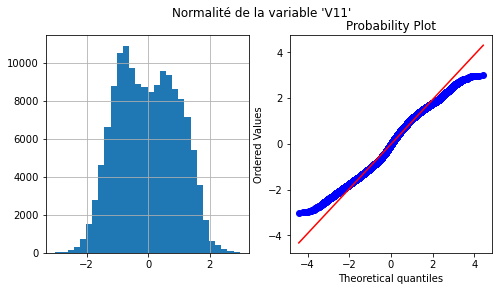

/home/ensai/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 146334.
  res = hypotest_fun_out(*samples, **kwds)


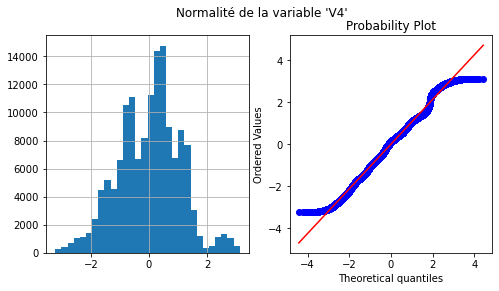

{'V17': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False},
 'V10': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False},
 'V12': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False},
 'V16': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False},
 'V14': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False},
 'V3': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False},
 'V7': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False},
 'V11': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False},
 'V4': {'Shapiro-Wilk': False, 'Skewness': True, 'Kurtosis': False}}

In [192]:
vars_dist_nor = check_normality_multiple(df_out, liste_caracteristiques)
vars_dist_nor 

In [193]:
import scipy.stats as stats
import matplotlib.pyplot as plt

def get_normal_variables(df, features):
    """
    Renvoie la liste des variables du dataframe 'df' qui ont une distribution normale selon plusieurs tests.
    
    Paramètres:
    df (pandas.DataFrame) : le dataframe contenant les variables à tester
    features (list) : la liste des noms de variables à tester
    
    Renvoie:
    list : la liste des variables ayant une distribution normale
    """
    normality_results = {}
    normal_variables = []
    
    for feature in features:
        # Test de Shapiro-Wilk
        _, p_value_shapiro = stats.shapiro(df[feature])
        
        # Test de Kolmogorov-Smirnov
        #_, p_value_ks, _ = stats.kstest(df[feature], 'norm')
        
        # Coefficient d'asymétrie et d'aplatissement
        skewness = stats.skew(df[feature])
        kurtosis = stats.kurtosis(df[feature])
        
        # Vérifier si la variable suit une loi normale selon tous les tests
        is_normal = (
            p_value_shapiro > 0.05 and
           # p_value_ks > 0.05 and
            abs(skewness) < 0.5 and
            abs(kurtosis - 3) < 1
        )
        
        # Rassembler les résultats
        normality_results[feature] = {
            'Shapiro-Wilk': p_value_shapiro > 0.05,
            #'Kolmogorov-Smirnov': p_value_ks > 0.05,
            'Skewness': abs(skewness) < 0.5,
            'Kurtosis': abs(kurtosis - 3) < 1
        }
        
        if is_normal:
            normal_variables.append(feature)
    
    return normal_variables

In [195]:
#vars_dist_nor = get_normal_variables(df, liste_caracteristiques)
vars_dist_nor = get_normal_variables(df_out, liste_caracteristiques);
vars_dist_nor

[]

In [60]:
def methode_ecart_type(df, n, caracteristiques):
    """
    Prend un dataframe df des caractéristiques et renvoie une liste d'indices correspondant aux observations 
    contenant plus de n outliers selon la méthode de l'écart-type.
    """
    indices_outliers = []
    
    for colonne in caracteristiques:
        # calcul de la moyenne et de l'écart-type des données
        moyenne_donnees = df[colonne].mean()
        ecart_type_donnees = df[colonne].std()
        
        # calcul de la valeur de coupure
        valeur_coupure = ecart_type_donnees * 3
        
        # Détermination d'une liste d'indices des outliers pour la colonne de caractéristique
        liste_outliers_colonne = df[(df[colonne] < moyenne_donnees - valeur_coupure) | (df[colonne] > moyenne_donnees + valeur_coupure)].index
        
        # ajout des indices d'outliers trouvés pour la colonne à la liste des indices d'outliers
        indices_outliers.extend(liste_outliers_colonne)
        
    # sélection des observations contenant plus de x outliers
    indices_outliers = Counter(indices_outliers)        
    observations_multi_outliers = list( k for k, v in indices_outliers.items() if v > n )
    
    # Calcul du nombre d'enregistrements en dessous et au-dessus de la borne inférieure et supérieure respectivement
    df1 = df[df[colonne] > moyenne_donnees + valeur_coupure]
    df2 = df[df[colonne] < moyenne_donnees - valeur_coupure]
    print('Nombre total d\'outliers :', df1.shape[0] + df2.shape[0])
    
    return observations_multi_outliers   



In [200]:
# détection des outliers
Outliers_ecart_type = methode_ecart_type(df, 1, liste_caracteristiques)
Outliers_ecart_type1 = methode_ecart_type(df_out, 1, liste_caracteristiques)


Nombre total d'outliers : 3094
Nombre total d'outliers : 54


In [201]:
# suppression des outliers
df_out2 = df.drop(Outliers_ecart_type, axis = 0).reset_index(drop=True)
df_out21 = df.drop(Outliers_ecart_type1, axis = 0).reset_index(drop=True)


/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` wi

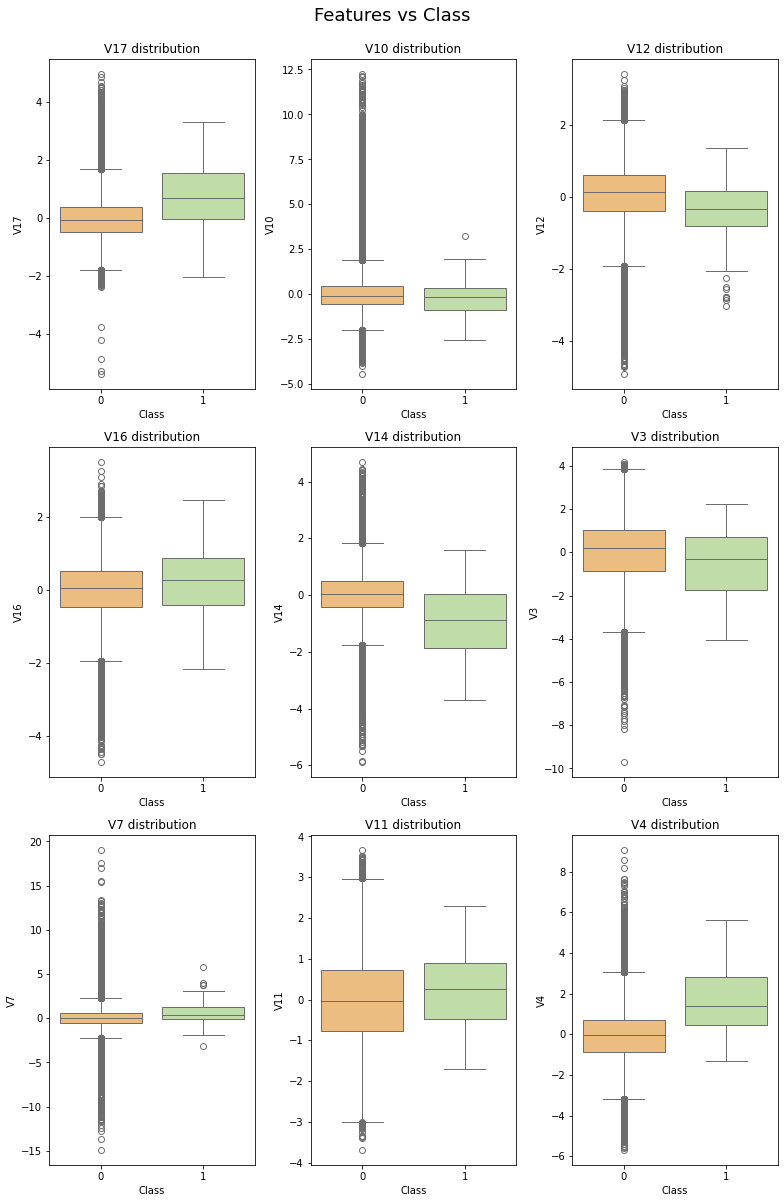

In [199]:
# Utilisation de la fonction
fig, axes = plot_features_by_class_boxplot(df_out2, liste_caracteristiques)

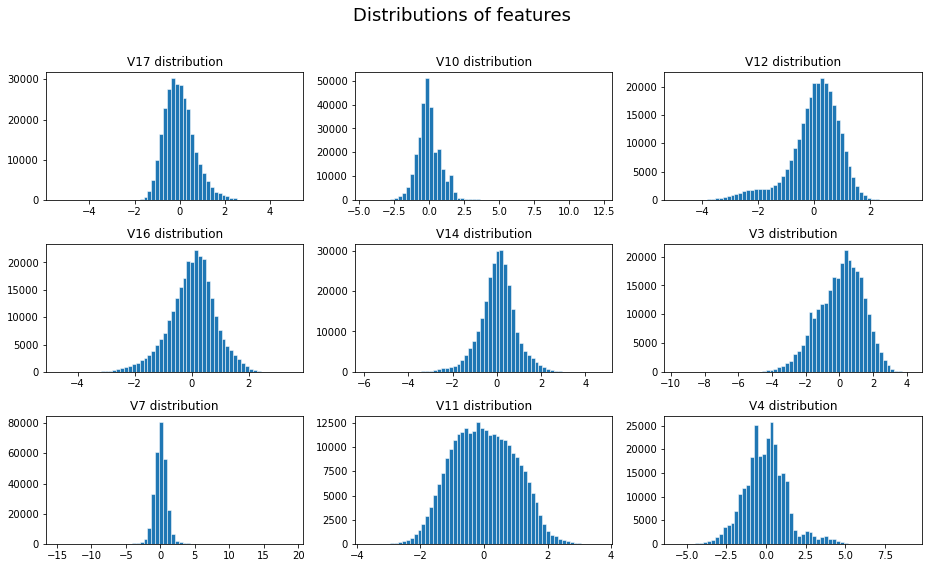

In [68]:
# Utilisation de la fonction
fig, axes = plot_feature_histograms(df_out2, liste_caracteristiques)

In [69]:
"""# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using Standard Deviation Method\n', size = 18)


axes[0,0].hist(df_out2['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out2['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out2['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out2['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out2['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out2['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out2['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out2['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out2['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()"""

'# Checking distributions of most important features after dropping outliers\n\nfig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))\nfig.suptitle(\'Distributions of most important features after dropping outliers using Standard Deviation Method\n\', size = 18)\n\n\naxes[0,0].hist(df_out2[\'V17\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[0,0].set_title("V17 distribution");\n\naxes[0,1].hist(df_out2[\'V10\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[0,1].set_title("V10 distribution");\n\naxes[0,2].hist(df_out2[\'V12\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[0,2].set_title("V12 distribution");\n\naxes[1,0].hist(df_out2[\'V16\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[1,0].set_title("V16 distribution");\n\naxes[1,1].hist(df_out2[\'V14\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[1,1].set_title("V14 distribution");\n\naxes[1,2].hist(df_out2[\'V3\'], bins=60, linewidth=0.5, edgecolor="white")\naxes[1,2].set_title("V3 distribution");\n\naxes

### Methode 2

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def detect_outliers_m2(df, stdev_threshold=3, features=None, n=1):
    """
    Détecte les observations aberrantes dans un dataframe.
    
    Paramètres:
    df (pandas.DataFrame): Le dataframe à analyser.
    stdev_threshold (float, optionnel): Le nombre d'écarts-types à utiliser comme seuil de détection des outliers (défaut : 3).
    features (list, optionnel): Une liste de noms de variables à analyser. Si non spécifié, toutes les variables sont analysées.
    n (int, optionnel): Le nombre minimum d'outliers pour qu'une observation soit considérée comme ayant plusieurs outliers (défaut : 1).
    
    Retourne:
    pandas.DataFrame: Le dataframe contenant les observations aberrantes.
    """
    if features is None:
        features = df.columns
    outlier_indices = []
    outlier_thresholds = {}
    
    for col in features:
        data_mean = df[col].mean()
        data_std = df[col].std()
        cut_off = data_std * stdev_threshold
        lower, upper = data_mean - cut_off, data_mean + cut_off
        outlier_thresholds[col] = (lower, upper)
        
        print(f"Pour la variable '{col}' :")
        print(f"La borne inférieure est : {lower:.2f}")
        print(f"La borne supérieure est : {upper:.2f}")
        print()
        
        # Détermination des indices des outliers pour cette caractéristique
        outlier_indices_feature = df[(df[col] < lower) | (df[col] > upper)].index
        outlier_indices.extend(outlier_indices_feature)
    
    outlier_mask = pd.DataFrame(index=df.index)
    for col, (lower, upper) in outlier_thresholds.items():
        outlier_mask[col] = (df[col] < lower) | (df[col] > upper)
    
    outliers = df.loc[outlier_mask.any(axis=1)]
    
    print(f"\nNombre d'observations aberrantes : {len(outliers)}")
    
    # Visualisation des observations aberrantes
    fig, axes = plt.subplots(len(features)//3 + 1, 3, figsize=(15, 10))
    axes = axes.ravel()
    for i, col in enumerate(features):
        sns.histplot(x=col, data=df, ax=axes[i], bins=50)
        axes[i].axvspan(xmin=outlier_thresholds[col][0], xmax=df[col].min(), alpha=0.2, color='red')
        axes[i].axvspan(xmin=outlier_thresholds[col][1], xmax=df[col].max(), alpha=0.2, color='red')
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()
    
    # Sélection des observations contenant plus de n outliers
    multi_outlier_observations = [k for k, v in Counter(outlier_indices).items() if v >= n]
    
    return multi_outlier_observations

In [239]:
liste_caracteristiques=['V17', 'V10', 'V12', 'V16', 'V14', 'V3', 'V7', 'V11', 'V4']

Pour la variable 'V17' :
La borne inférieure est : -1.75
La borne supérieure est : 1.51

Pour la variable 'V10' :
La borne inférieure est : -2.05
La borne supérieure est : 1.97

Pour la variable 'V12' :
La borne inférieure est : -1.86
La borne supérieure est : 2.26

Pour la variable 'V16' :
La borne inférieure est : -1.94
La borne supérieure est : 2.11

Pour la variable 'V14' :
La borne inférieure est : -1.82
La borne supérieure est : 1.78

Pour la variable 'V3' :
La borne inférieure est : -3.39
La borne supérieure est : 3.69

Pour la variable 'V7' :
La borne inférieure est : -2.03
La borne supérieure est : 2.05

Pour la variable 'V11' :
La borne inférieure est : -2.96
La borne supérieure est : 2.93

Pour la variable 'V4' :
La borne inférieure est : -3.19
La borne supérieure est : 3.21


Nombre d'observations aberrantes : 1353


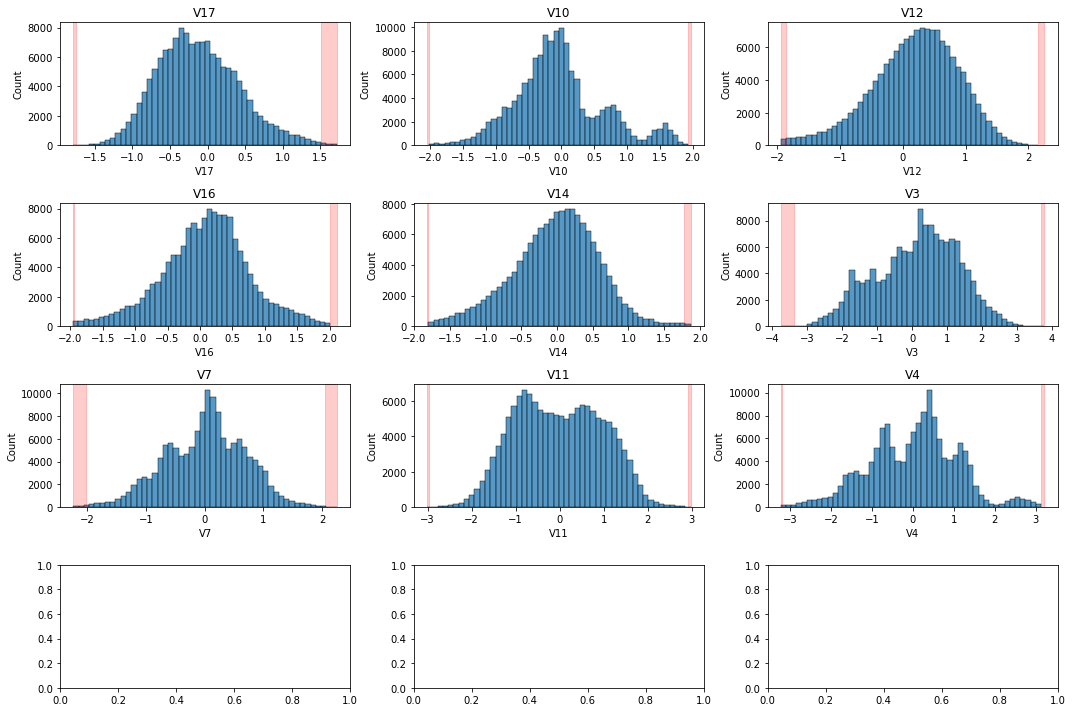

In [240]:
outliers = detect_outliers_m2(df_out, 3, liste_caracteristiques)

In [241]:
outliers


[1295,
 2287,
 2301,
 2302,
 2315,
 2471,
 2548,
 3021,
 3157,
 3225,
 3876,
 4171,
 4705,
 4706,
 4707,
 4708,
 5066,
 5218,
 5280,
 5651,
 5691,
 5863,
 6285,
 6472,
 7038,
 7156,
 7456,
 7475,
 7479,
 7584,
 7981,
 8177,
 8274,
 8299,
 8596,
 8896,
 9161,
 9403,
 9542,
 9796,
 10472,
 10639,
 10729,
 10830,
 11359,
 11605,
 12161,
 12298,
 12891,
 13118,
 13901,
 13918,
 13925,
 14125,
 14618,
 15123,
 15150,
 15233,
 15729,
 15754,
 15886,
 16150,
 16198,
 16684,
 16991,
 17017,
 17420,
 17906,
 18284,
 18820,
 18932,
 18952,
 19058,
 20074,
 20146,
 20276,
 20403,
 21021,
 21245,
 21308,
 21422,
 21761,
 22344,
 22411,
 22438,
 22661,
 22860,
 24597,
 24663,
 25159,
 25226,
 25393,
 25516,
 26051,
 27131,
 27378,
 27556,
 27631,
 27957,
 28298,
 28402,
 28441,
 28829,
 29176,
 29514,
 29547,
 30112,
 30253,
 30385,
 30516,
 30655,
 30738,
 31059,
 31257,
 31296,
 31336,
 31395,
 31510,
 31595,
 32323,
 32698,
 32835,
 33229,
 33264,
 33572,
 33979,
 34227,
 35033,
 35206,
 35475,


In [242]:
len(outliers)

1353

Le choix de la valeur 3 pour le paramètre `stdev_threshold` dans la fonction `detect_outliers()` est une décision courante et généralement considérée comme une bonne pratique pour la détection des outliers.

Voici quelques explications sur ce choix :

1. **Règle empirique des 3 écarts-types** :
   - Cette règle indique que dans une distribution normale, environ 99,7% des observations se situent dans un intervalle de ±3 écarts-types autour de la moyenne.
   - Par conséquent, les observations se trouvant à plus de 3 écarts-types de la moyenne sont généralement considérées comme des outliers potentiels.

2. **Compromis entre sensibilité et spécificité** :
   - Un seuil de 3 écarts-types offre un bon équilibre entre la sensibilité (capacité à détecter les vrais outliers) et la spécificité (éviter de considérer comme outliers des observations qui ne le sont pas).
   - Des seuils plus stricts (comme 2 écarts-types) auraient tendance à détecter plus d'outliers, mais aussi plus de "faux positifs". 
   - Des seuils plus larges (comme 4 écarts-types) seraient plus conservateurs et détecteraient moins d'outliers, ce qui pourrait faire manquer des observations importantes.

3. **Pratique courante et recommandations** :
   - L'utilisation d'un seuil de 3 écarts-types est une pratique très répandue dans de nombreux domaines pour la détection des outliers.
   - C'est également la recommandation généralement faite dans la littérature sur l'analyse exploratoire des données et le traitement des valeurs aberrantes.

Bien sûr, le choix du seuil peut dépendre du contexte de votre analyse et des caractéristiques de vos données. Mais 3 écarts-types est souvent un bon point de départ qui offre un bon compromis entre sensibilité et spécificité pour la détection des outliers.

/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` wi

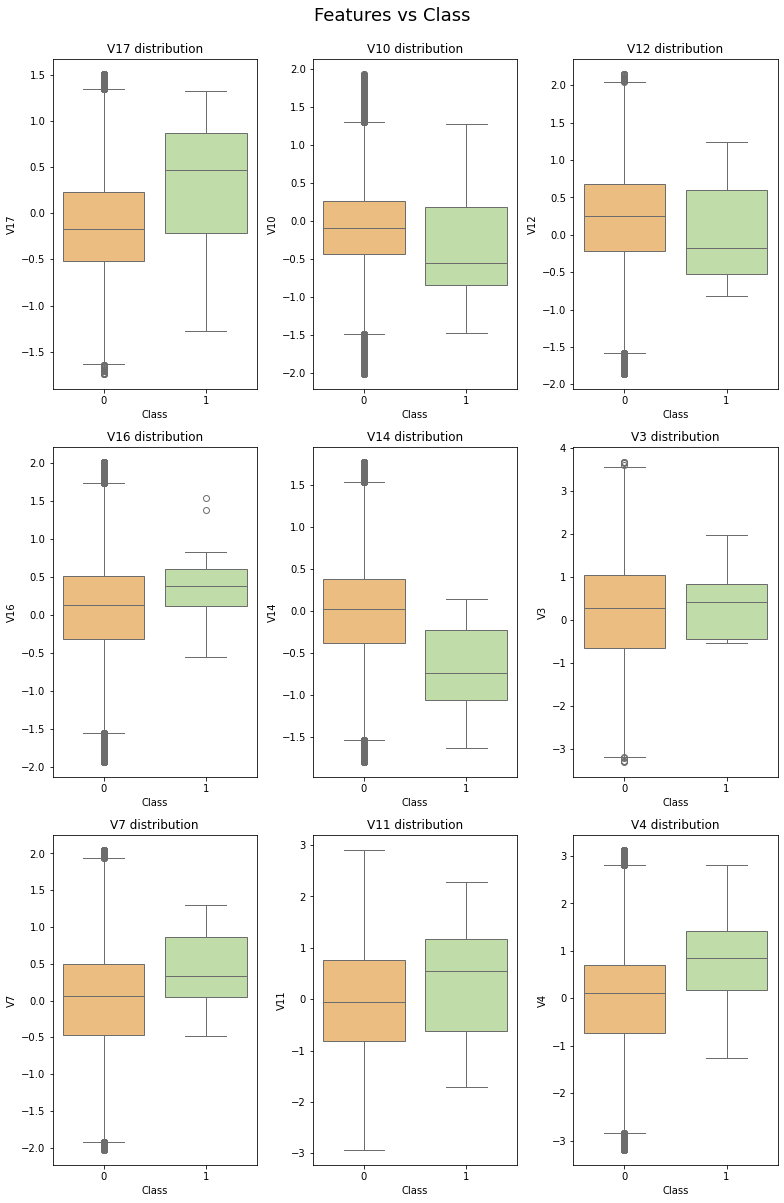

In [218]:

# suppression des outliers
df_out_m2 = df_out.drop(outliers, axis = 0).reset_index(drop=True)

# Utilisation de la fonction
fig, axes = plot_features_by_class_boxplot(df_out_m2, liste_caracteristiques)

# 4. Z-score method

While calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. Z-score is used to convert the data into another dataset with mean = 0.

Z-score describes the position of a raw score in terms of its distance from the mean, when measured in standard deviation units.

This technique assumes a **Gaussian distribution** of the data. The outliers are the data points that are in the tails of the distribution.

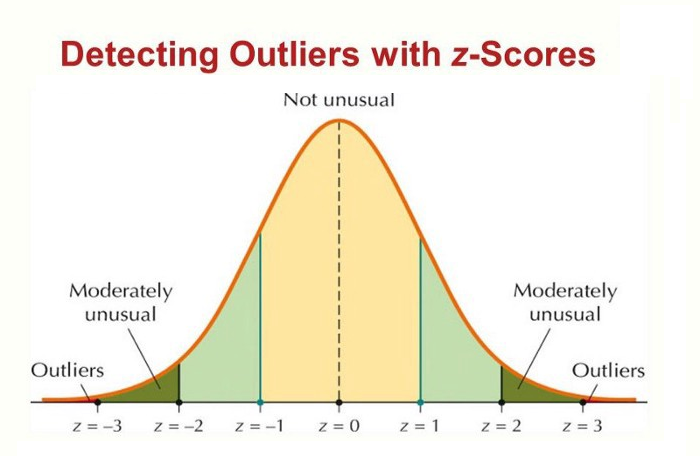

In [219]:
def methode_z_score(df, n, caracteristiques):
    """
    Prend un DataFrame df de caractéristiques et renvoie une liste d'index correspondant aux observations
    contenant plus de n outliers selon la méthode du z-score.
    """
    liste_outliers = []
    
    for colonne in caracteristiques:
        # calculer la moyenne et l'écart-type des données du DataFrame
        moyenne_donnees = df[colonne].mean()
        ecart_type_donnees = df[colonne].std()
        seuil = 3
        
        z_score = abs((df[colonne] - moyenne_donnees) / ecart_type_donnees)
        
        # Déterminer une liste d'index des outliers pour la colonne de caractéristique
        liste_outliers_colonne = df[z_score > seuil].index
        
        # ajouter les index d'outliers trouvés pour la colonne à la liste des index d'outliers
        liste_outliers.extend(liste_outliers_colonne)
        
    # sélectionner les observations contenant plus de x outliers
    liste_outliers = Counter(liste_outliers)        
    multi_outliers = list(k for k, v in liste_outliers.items() if v > n)
    
    # Calculer le nombre d'enregistrements outliers
    df_outliers = df[z_score > seuil]
    print('Nombre total d\'outliers :', df_outliers.shape[0])
    
    return multi_outliers

In [228]:
#sous reserve de la normalité
# detecting outliers
Outliers_z_score = methode_z_score(df,1,feature_list)

# dropping outliers
df_out3 = df.drop(Outliers_z_score, axis = 0).reset_index(drop=True)

Nombre total d'outliers : 4076


/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` wi

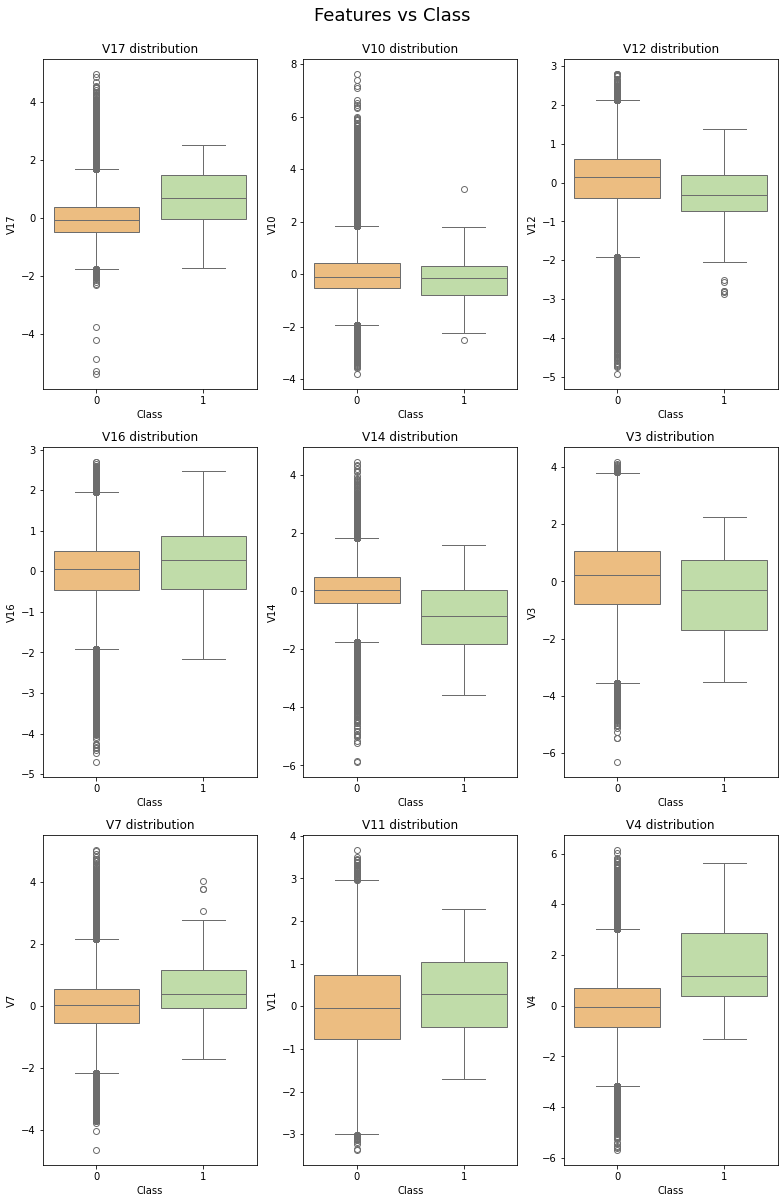

In [229]:
# Utilisation de la fonction
fig, axes = plot_features_by_class_boxplot(df_out3, liste_caracteristiques)

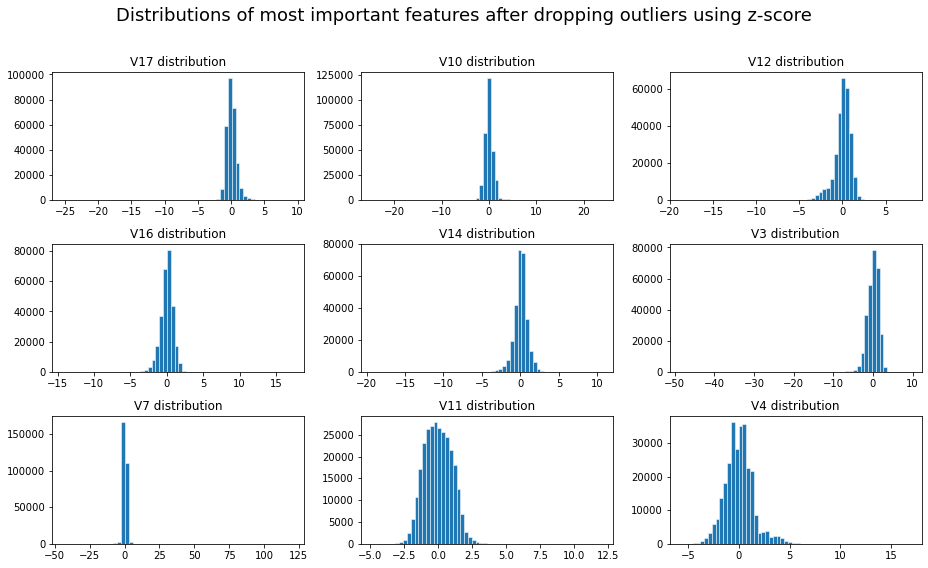

In [223]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using z-score\n', size = 18)

axes[0,0].hist(df_out3['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out3['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out3['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out3['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out3['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out3['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out3['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out3['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out3['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

# 5. Modified z-score

Z-scores can be affected by unusually large or small data values. If there is one extreme value, the z-score corresponding to that point will also be extreme which is why a more robust way to detect outliers is to use a modified z-score. 

It has the potential to significantly move the mean away from its actual value. Modified z-score is calculated as:

Modified z-score = 0.6745(xi – x̃) / MAD

where:

* xi: A single data value
* x̃: The median of the dataset
* MAD: The median absolute deviation of the dataset

The median absolute deviation (MAD) is a robust statistic of variability that measures the spread of a dataset. It’s less affected by outliers than other measures of dispersion like standard deviation and variance. If your data is normal, the standard deviation is usually the best choice for assessing spread. However, if your data isn’t normal, the MAD is one statistic you can use instead.

MAD = median(|xi – xm|)

where:
* xi: The ith value in the dataset
* xm: The median value in the dataset

### Important note 

To calculate MAD you can use:
* scipy.stats
* statsmodels
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_abs_deviation.html
https://www.statsmodels.org/dev/generated/statsmodels.robust.scale.mad.html

The formula from scipy.stats doesn't need any change in parameters.

The the formula from statsmodels (statsmodels.robust.scale.mad) howeaver computes a robust estimate of the standard deviation assuming a normal distribution by scaling the result by a factor of roughly 0.67.

To avoid using this scaling factor we have to set c = 1 as follows: robust.mad(data, c=1)

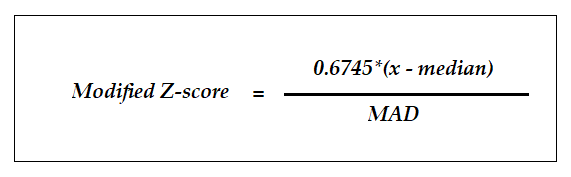

In [232]:
from scipy.stats import median_abs_deviation

def methode_z_score_modifie(df, n, caracteristiques):
    """
    Prend un DataFrame df de caractéristiques et renvoie une liste d'index correspondant aux observations
    contenant plus de n outliers selon la méthode du z-score modifié.
    """
    liste_outliers = []
    
    for colonne in caracteristiques:
        # calculer la moyenne et l'écart-type des données du DataFrame
        moyenne_donnees = df[colonne].mean()
        ecart_type_donnees = df[colonne].std()
        seuil = 3
        MAD = median_abs_deviation
        
        mod_z_score = abs(0.6745 * (df[colonne] - moyenne_donnees) / MAD(df[colonne]))
                
        # Déterminer une liste d'index des outliers pour la colonne de caractéristique
        liste_outliers_colonne = df[mod_z_score > seuil].index
        
        # ajouter les index d'outliers trouvés pour la colonne à la liste des index d'outliers
        liste_outliers.extend(liste_outliers_colonne)
        
    # sélectionner les observations contenant plus de x outliers
    liste_outliers = Counter(liste_outliers)        
    multi_outliers = list(k for k, v in liste_outliers.items() if v > n)
    
    # Calculer le nombre d'enregistrements outliers
    df_outliers = df[mod_z_score > seuil]
    print('Nombre total d\'outliers :', df_outliers.shape[0])
    
    return multi_outliers

In [233]:
# detecting outliers
Outliers_z_score = methode_z_score_modifie(df,1,feature_list)

# dropping outliers
df_out4 = df.drop(Outliers_z_score, axis = 0).reset_index(drop=True)

Nombre total d'outliers : 33055


/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Class', y=col, palette='Spectral')
/tmp/ipykernel_2003347/39187461.py:18: FutureWarning: 

Passing `palette` wi

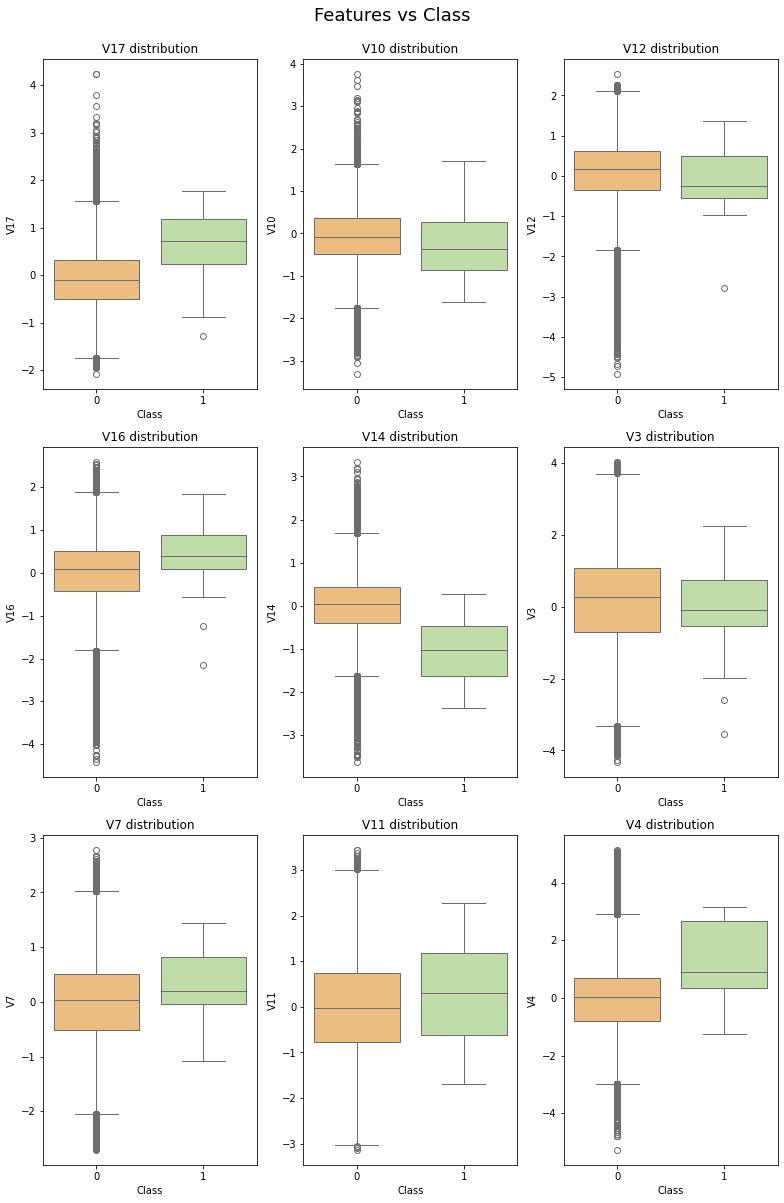

In [234]:
# Utilisation de la fonction
fig, axes = plot_features_by_class_boxplot(df_out4, liste_caracteristiques)

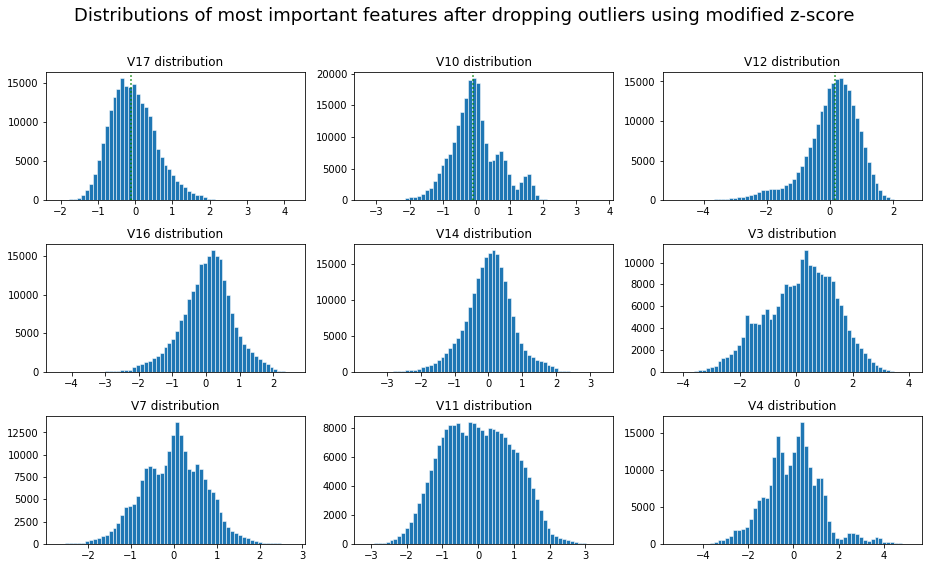

In [22]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using modified z-score\n', size = 18)

axes[0,0].hist(df_out4['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].axvline(np.median(df_out4['V17']), ls=':', c='g', label="Median")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out4['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].axvline(np.median(df_out4['V10']), ls=':', c='g', label="Median")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out4['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].axvline(np.median(df_out4['V12']), ls=':', c='g', label="Median")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out4['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out4['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out4['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out4['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out4['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out4['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

# 6. Isolation Forest

Isolation Forest(IF) is similar to Random Forest and it is build based on decision trees. There are no pre-defined labels here. It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data. 

The Isolation Forest (iForest) algorithm was initially proposed by Fei Tony Liu, Kai Ming Ting and Zhi-Hua Zhou in 2008. The authors took advantage of two quantitative properties of anomalous data points in a sample:

1. Few - they are the minority consisting of fewer instances and
2. Different - they have attribute-values that are very different from those of normal instances

Since the Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, this should make them easier to identify.

Isolation Forest does not assume normal distribution and is able to detect outliers at a multi-dimensional level. Isolation Forest is computationally efficient: the algorithm has a linear time complexity with a low constant and a low memory requirement. Therefore, it scales well to large data sets.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

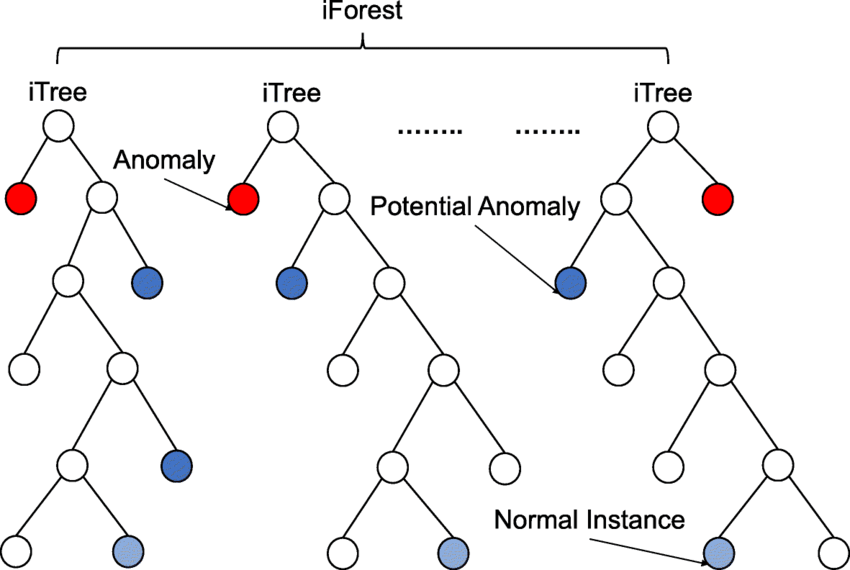

In [243]:
from sklearn.ensemble import IsolationForest

df5 = df.copy()
df5 = df5.drop(['Class'], axis=1)

**Number of estimators**: n_estimators refers to the number of base estimators or trees in the ensemble (the number of trees that will get built in the forest). This is an optional integer parameter. The default value is 100.

**Max samples**: max_samples is the number of samples to be drawn to train each base estimator. The default value of max_samples is 'auto' (256): If max_samples is larger than the number of samples provided, all samples will be used for all trees (no sampling).

**Contamination**: it refers to the expected proportion of outliers in the data set (i.e. the proportion of outliers in the data set). This is used when fitting to define the threshold on the scores of the samples. The default value is 'auto'. If ‘auto’, the threshold value will be determined as in the original paper of Isolation Forest. If float, the contamination should be in the range (0, 0.5].

**Max features**: All the base estimators are not trained with all the features available in the dataset. It is the number of features to draw from the total features to train each base estimator or tree.The default value of max features is 1.

In [244]:
model=IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.1), max_features=1.0)
model.fit(df5)

IsolationForest(contamination=0.1, n_estimators=150)

### Adding the scores and anomaly column
These columns are going to be added to the data frame df. 

Negative score value "-1" for the value of anomaly columns indicate the presence of anomaly. Value of "1" for the anomaly represents the normal data.

In [245]:
scores=model.decision_function(df5)
anomaly=model.predict(df5)

df5['scores']=scores
df5['anomaly']=anomaly

df5.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,scores,anomaly
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.079103,1
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.088356,1
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.015043,1
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.042683,1
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.074922,1
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0.096056,1
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0.093516,1
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,-0.024582,-1
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0.069770,1
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0.088766,1


In [246]:
anomaly = df5.loc[df5['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is:', len(anomaly))

Total number of outliers is: 28481


In [247]:
df5[df5['anomaly']==-1].head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,scores,anomaly
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,-0.024582,-1
18,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,0.345173,...,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,-0.051974,-1
51,-1.004929,-0.985978,-0.038039,3.710061,-6.631951,5.122103,4.371691,-2.006868,-0.278736,-0.230873,...,-0.381671,0.969719,0.019445,0.570923,0.333278,0.857373,-0.075538,1402.95,-0.092095,-1
69,-1.923213,-0.870482,2.320170,1.988776,0.417091,-0.380014,0.472139,-0.557333,-0.649079,1.410889,...,-0.779268,1.086055,0.518863,-0.363712,3.065576,-0.589022,-0.396110,35.00,-0.020386,-1
82,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,1.46,-0.106019,-1
83,-1.198968,-1.474100,1.840326,-4.515824,0.327567,-0.174469,0.959726,-1.026456,1.700435,-0.078942,...,0.334614,-0.364541,-0.310186,-0.302599,-1.243924,-1.123457,-0.734351,89.17,-0.031464,-1
85,-4.575093,-4.429184,3.402585,0.903915,3.002224,-0.491078,-2.705393,0.666451,1.922216,-0.614312,...,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,-0.041545,-1
89,-0.773293,-4.146007,-0.932038,0.027094,-1.698307,0.460188,0.737344,-0.314216,-0.842673,0.017276,...,0.026123,-1.134769,-0.654958,0.098386,-0.209150,-0.171709,0.208057,1142.02,-0.021539,-1
102,0.298503,2.142722,-1.542143,1.561332,0.938108,-2.145673,1.405569,-0.778459,0.328636,0.127497,...,-0.000235,0.092174,0.586205,-0.397314,-0.480949,0.251145,-0.242279,0.78,-0.009688,-1
104,-1.766645,2.352984,-0.009955,-0.363736,1.460953,-0.204833,0.905819,-3.384123,0.388546,0.791069,...,-0.883218,-0.247698,-0.758606,0.086450,0.202790,-0.898858,-0.944337,0.76,-0.015873,-1


In [248]:
# dropping outliers
df_out5 = df5.drop(anomaly_index, axis = 0).reset_index(drop=True)

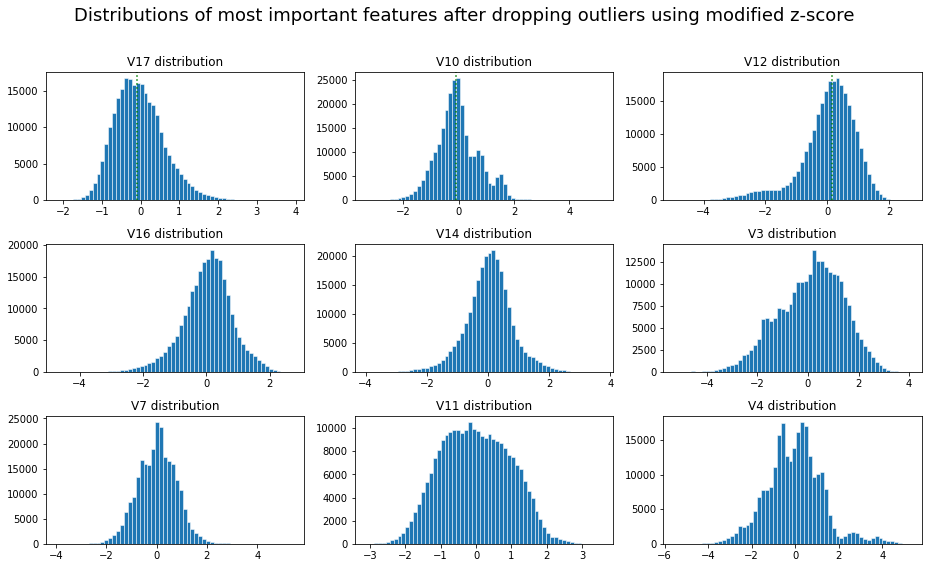

In [30]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using modified z-score\n', size = 18)

axes[0,0].hist(df_out5['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].axvline(np.median(df_out5['V17']), ls=':', c='g', label="Median")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out5['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].axvline(np.median(df_out5['V10']), ls=':', c='g', label="Median")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out5['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].axvline(np.median(df_out5['V12']), ls=':', c='g', label="Median")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out5['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out5['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out5['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out5['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out5['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out5['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

# 7. DBSCAN - Density-Based Spatial Clustering of Applications with Noise

DBSCAN is a powerful density-based data clustering algorithm. Clustering is an unsupervised learning technique where we try to group the data points based on specific characteristics. DBSCAN was proposed by Martin Ester et al. in 1996. It works on the assumption that clusters are dense regions in space separated by regions of lower density.

To cluster data points DBSCAN algorithm separates the high-density regions of the data from the low-density areas. It uses distance and a minimum number of points per cluster to classify a point as an outlier. This approch is similar to the K-mean clustering.

PARAMETERS:

**Epsilon** is the radius of the circle to be created around each data point to check the density.

**minPoints** is the minimum number of data points required inside that circle for that data point to be classified as a Core point. This includes the point itself.

In higher dimensions the circle becomes hypersphere, epsilon becomes the radius of that hypersphere, and minPoints is the minimum number of data points required inside that hypersphere.

**DBSCAN algorithm doesn't make assumptions about how data are distributed.**

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [31]:
df6 = df.copy()
df6 = df6.drop(['Class'], axis=1)

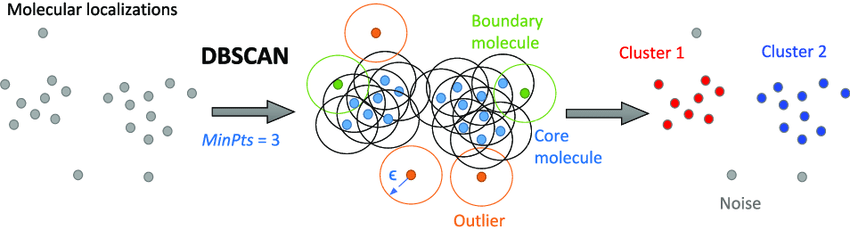

Let’s first run DBSCAN without any parameter optimization and see the results.

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# scale data first
X = StandardScaler().fit_transform(df6.values)

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [34]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('The number of clusters in dataset is:', n_clusters_)

The number of clusters in dataset is: 39


The number of clusters does not include outliers/noise in the dataset.

Labels are the labels of the clusters. If the label is -1, then the observation is an outlier/noise.

In [35]:
pd.Series(labels).value_counts()

 0     197235
 1      32473
-1      20243
 9      16078
 2      12290
 5       2047
 7       1416
 10       828
 3        333
 24       287
 12       214
 16       213
 13       206
 17       181
 11       170
 18        81
 4         80
 30        48
 37        36
 20        32
 22        32
 23        25
 31        24
 14        21
 29        20
 15        19
 25        18
 28        17
 26        16
 33        16
 21        15
 32        14
 34        12
 35        12
 38        10
 6         10
 8         10
 36        10
 19         8
 27         7
dtype: int64

# Thanks, upvote if you liked it :)